In [39]:
using Pkg

Pkg.add("DifferentialEquations")
Pkg.add("PyPlot")
Pkg.add("SpecialFunctions")
Pkg.add("PyCall")
Pkg.add("LsqFit")
Pkg.add("Statistics")
Pkg.add("JLD")


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Chan

In [40]:
using DifferentialEquations
using PyPlot
using SpecialFunctions
using PyCall
using LsqFit
using Statistics
using JLD

In [41]:


rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.sans-serif"] = "Nimbus Sans"
rc("font", family="sans-serif")
rc("font", size=10)
rc("svg", fonttype="none")

Systems of equations implemented is:
\begin{align}
    d\alpha &= (b - \alpha + \alpha^\dagger (\lambda - g^2 \alpha^2))d\tau + \sqrt{\lambda - g^2\alpha^2} dW_1 \\
    d\alpha^\dagger &= (b - \alpha^\dagger + \alpha (\lambda - g^2 \alpha^{\dagger 2}))d\tau + \sqrt{\lambda - g^2\alpha^{\dagger 2}} dW_2 \\
\end{align}
Here, $g$ is the quantum noise level of the OPO, and $\lambda$ is the field fraction above threshold, and $b$ is a dimensionless bias. The bias is defined such that in absence of the OPO, a bias $b$ corresponds to having $b$^2 photons inside the cavity in the steady state. In terms of these parameters, the steady state photon number inside the cavity due to the OPO interaction, and neglecting the bias is $n = (\lambda - 1 + g^2)/ g^2 \approx (\lambda - 1)/g^2$. The approximation holds for macroscopic systems where $g$ is small.

In [42]:
#returns Problem object which can be fed into Julia DifferentialEquations solver
#parameters are as defined above
#u0 is the initial condition. To start with an initial cavity field of α0, u0 = [α0, α0].


#denote drift term in terms of original 0 values. 
function get_SDE_problem(g0, λ, b, u0, tspan)
    function drift(du,u,p,t)
        du[1] = b - u[1] + u[2]*(λ - g0^2*u[1]^2)
        du[2] = b - u[2] + u[1]*(λ - g0^2*u[2]^2)
    end
    
    function diffusion(du,u,p,t)
        du[1] = sqrt(λ - g0^2*u[1]^2)
        du[2] = sqrt(λ - g0^2*u[2]^2)
    end
    
    problem = SDEProblem(drift, diffusion, u0, tspan)
    return problem
end


#modified version of the above, which takes three possible "models" into account
function get_SDE_problem(g0, λ, b, tspan, model::Symbol)
    if model == :BIAS
        u0 = [0., 0.]
    elseif model == :INITIAL
        u0 = b*[1., 1.]
        b = 0.
    elseif model == :BIAS_AND_INITIAL
        u0 = b*[1., 1.]
    else
        error("Please enter a valid model.")
    end
    function drift(du,u,p,t)
        du[1] = b - u[1] + u[2]*(λ - g0^2*u[1]^2)
        du[2] = b - u[2] + u[1]*(λ - g0^2*u[2]^2)
    end

    function diffusion(du,u,p,t)
        du[1] = sqrt(λ - g0^2*u[1]^2)
        du[2] = sqrt(λ - g0^2*u[2]^2)
    end
    
    problem = SDEProblem(drift, diffusion, u0, tspan)
    return problem
end

get_SDE_problem (generic function with 2 methods)

In [43]:
#runs N instances of an SDE problem and averages the steady state phases to give a probability between 0 and 1
function get_probability(problem, N)
    phases = 0.0*zeros(N)
    for i in 1:N
        sol = solve(problem);
        
        t = sol.t
        u = sol.u;

        αsol = [uu[1] for uu in u]
        final = αsol[end]
        if final > 0
            phases[i] = 1.
        else
            phases[i] = 0.
        end
    end
    p_plus = sum(phases)/N
    return p_plus
end

#runs N instances of an SDE problem and returns trajectories
function get_trajectories(problem, N, dt)
    sol = solve(problem, saveat=dt);
    tout = sol.t
    
    phases = 0.0*zeros(N)
    trajectories = 0.0*zeros(N, length(tout))
    for i in 1:N
        sol = solve(problem, saveat=dt);
         u = sol.u;

        αsol = [uu[1] for uu in u]
        βsol = [uu[2] for uu in u]
        X = (βsol .+ αsol) / 2 #taking the "real" quadrature only
        
        trajectories[i,:] = X
        
        #phase determination
        final = αsol[end]
        if final > 0
            phases[i] = 1.
        else
            phases[i] = 0.
        end
        
    end
    p_plus = sum(phases)/N
    return tout, trajectories, p_plus
end

#returns steady state theoretical field value for OP)
function steady_α(g, λ)
    return sqrt(λ - 1 + g^2)/g
end

steady_α (generic function with 1 method)

In [44]:
function probability_from_sample(sample)
    result = 0.0*zeros(length(sample))
    for (i, s) in enumerate(sample)
        if s == 0
            result[i] = 0.5
        elseif s > 0
            result[i] = 1.
        else
            result[i] = 0.
        end
    end
    return sum(result)/length(sample)
end

probability_from_sample (generic function with 1 method)

## Panels for main text Fig. 3

In [45]:
g0 = 1e-5 #small g for macroscopic OPO
λ = 2.    #fraction above threshold (in field)
b = 1   #bias field

1

In [46]:
α0 = steady_α(g0, λ)
n0 = α0^2

1.0000000000999998e10

In [47]:
#initial condition
u0 = 0. *[1, 1]

#timespan to run, with units of cavity lifetimes (1/γ)
tspan = (0.0, 20.0)

#get problem with these parameters
problem = get_SDE_problem(g0, λ, b, u0, tspan);

In [48]:
#number of trajectories
N = 500

#run trajectories
@time tout, trajectories, p_plus = get_trajectories(problem, N, 0.1);

 26.706383 seconds (38.85 M allocations: 14.804 GiB, 11.36% gc time, 95.46% compilation time)


In [49]:
mean_trajectory = [mean(trajectories[:,i]) for i in 1:length(tout)]
trajectory_std = [std(trajectories[:,i]) for i in 1:length(tout)];

theory_pos = 0.0*zeros(length(tout))
for i in 1:length(tout)
    μ = mean_trajectory[i]
    σ = trajectory_std[i]
    theory_pos[i] = 0.5*(1 + erf(μ/(√2 * σ)))
end

In [50]:
pos_traj = [probability_from_sample(trajectories[:,i]) for i in 1:length(tout)];

In [51]:
kslices = [2, 50, 118, 200]; #sample points at which to take time slices for probabilities

In [2]:
figure(figsize=(4.6,2))

#subplot(211)

sample_trajectories = trajectories[1:5:end,:]
N_traj = size(sample_trajectories)[1]

for i in 1:N_traj
    traj = sample_trajectories[i,:]
    if traj[end] > 0
        plot(tout, traj', "blue", alpha=0.02);
    else
        plot(tout, traj', "red", alpha=0.02);
    end
end



#plot(tout, trajectories[1:50:end,:]', "red", alpha=0.05);
#plot(tout, mean_trajectory, "black")
# plot(tout, mean_trajectory .+ trajectory_std, linestyle="dashed", "red")
# plot(tout, mean_trajectory -+ trajectory_std, linestyle="dashed", "red")

vlines(tout[kslices], -1.5*α0, 1.5*α0, linestyle="dashed", "black", alpha=0.5)

xlim(tspan[1], tspan[end])
#xlim(380, 420)
ylim(-1.5*α0, 1.5*α0)
#hlines([α_inflection], tspan[1], tspan[2])
xticks(0:5:20)
xlabel("t / γ")
ylabel("α")

tight_layout()

# subplot(212)

# plot(tout, pos_traj, "black")
# #plot(tout, theory_pos)
# ylim(0.0, 1.1)

# xlim(tspan[1], tspan[end])
# hlines([0.5], tspan[1], tspan[end], "black", linestyle="dashed")

# xlabel("t / γ")
# ylabel("Probability")

# tight_layout()

# pos_traj[end]

#savefig("macroscopic_trajectories_bias.svg", dpi=600)

LoadError: UndefVarError: `figure` not defined

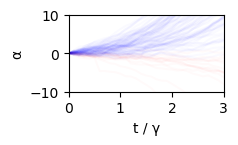

findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
f

PyObject Text(24.000000000000007, 0.5, 'α')

In [76]:
figure(figsize=(2,1))

for i in 1:N_traj
    traj = sample_trajectories[i,:]
    if traj[end] > 0
        plot(tout, traj', "blue", alpha=0.02);
    else
        plot(tout, traj', "red", alpha=0.02);
    end
end
#plot(tout, mean_trajectory, "black")
# plot(tout, mean_trajectory .+ trajectory_std, linestyle="dashed", "red")
# plot(tout, mean_trajectory -+ trajectory_std, linestyle="dashed", "red")

#vlines(tout[kslices], -1.2*α0, 1.2*α0, linestyle="dotted", "black", alpha=0.5)

xlim(0.0, 3)
#xlim(380, 420)
ymax = 10
ylim(-ymax, ymax)
#hlines([α_inflection], tspan[1], tspan[2])
xticks(0:1:3)
xlabel("t / γ")
ylabel("α")

#savefig("macroscopic_trajectories_gain_zoom.svg")





findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
f

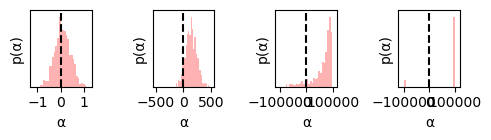

findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
f

In [54]:
figure(figsize=(5,1.5))
for (i, k) in enumerate(kslices)
    slice = trajectories[:,k]
    
    bound = maximum(abs.(slice))
    
    subplot(1,4,i)
    n, bins, patches = hist(slice, bins=27, density=true, color="red", alpha=0.3);
    
    ymax = 1.1*maximum(n)
    
    vlines([0.], 0, ymax, "black", linestyle="dashed")
    ylim(0, ymax)
    xlim(-1.2*bound, 1.2*bound)
    yticks([])
    #xticks([])
    xlabel("α")
    ylabel("p(α)")
end

tight_layout()
#xlim(-1.2*α0, 1.2*α0)

#savefig("macroscopic_probability_evolution.svg")

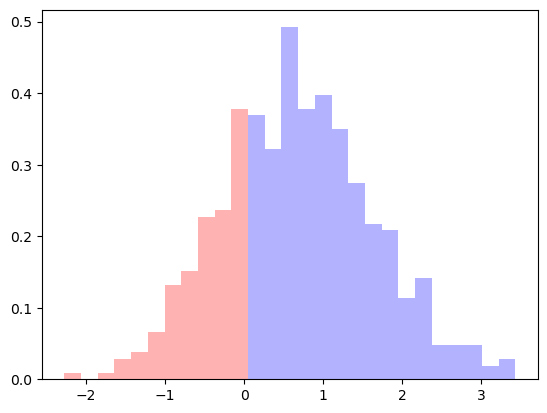

findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
f

In [55]:
slice = trajectories[:,6]
n, bins, patches = hist(slice, bins=27, density=true, color="red", alpha=0.3);

for r in patches
    xval = r.get_x()
    if xval > 0.
        r.set_facecolor("blue")
    end
end

## Results are independent of g

In [56]:
function get_tmax(λ, α0)
    return 3*log(α0)/(λ-1)
end

get_tmax (generic function with 1 method)

In [57]:
g0 = 1e-3
λ = 2
b = 0.8

α0 = steady_α(g0, λ)

1000.000499999875

In [58]:
tmax = get_tmax(λ, α0)

20.72326733694566

In [59]:
#initial condition
u0 = 0. *[1, 1]

#timespan to run, with units of cavity lifetimes (1/γ)
tspan = (0.0, tmax)

#get problem with these parameters
problem = get_SDE_problem(g0, λ, b, u0, tspan);

In [60]:
N = 500
tout, trajectories, p_plus = get_trajectories(problem, N, 0.1);

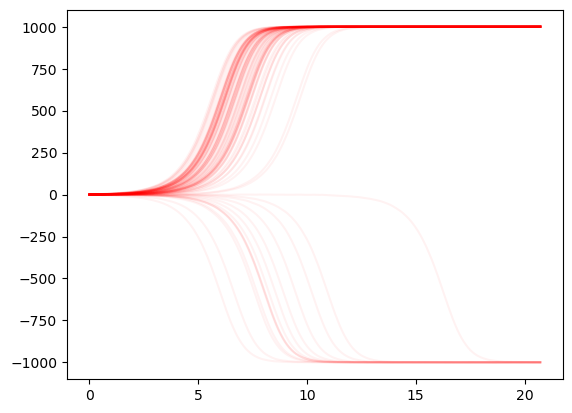

findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Nimbus Sans
f

In [61]:
plot(tout, trajectories[1:5:end,:]', "red", alpha=0.05);

In [62]:
#This cell runs simulations for a fixed bias level, and values of g selected across many orders of magnitude
#in order to show that the probabilities are independent of g for small g

gvals = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
gprobs = 0.0*gvals

N = 500

for (i, g0) in enumerate(gvals)
    α0 = steady_α(g0, λ)
    tmax = get_tmax(λ, α0)
    problem = get_SDE_problem(g0, λ, b, u0, tspan);
    p = get_probability(problem, N)
    gprobs[i] = p
end

In [63]:
gprobs

5-element Vector{Float64}:
 0.87
 0.87
 0.866
 0.83
 0.862

## Pump dependence for different models

In [64]:
model_erf(x, p) = 0.5*(erf.(x/p[1]) .+ 1)
lin(x,p) = p[1]*x .+ p[2]

lin (generic function with 1 method)

In [65]:
bias = range(-6, 6, length=31)
pumps = [2., 4., 6., 8.]
models = [:BIAS, :INITIAL, :BIAS_AND_INITIAL]

N = 4000

4000

The commented cell below runs many trajectories to compute probability as a function of bias field for different bias models, and pump fractions above threshold. This takes some time to run, so the resulting data is provided in all_models.jld, which can be loaded as seen below.

In [66]:
# all_models = Dict()

# for model in models
#     probs = 0.0*zeros(length(pumps), length(bias))
#     for (i, b) in enumerate(bias)
#         for (j, λ) in enumerate(pumps)
#             u0 = 0*[b, b]
#             problem = get_SDE_problem(g0, λ, b, tspan, model)
#             prob = get_probability(problem, N)
#             probs[j,i] = prob
#         end
#     end
#     all_models[model] = probs
# end

In [67]:
# using JLD

# save("all_models.jld", "data", all_models)

In [68]:
#loading precomputed data

all_models = load("all_models.jld")["data"];

LoadError: ArgumentError: No file exists at given path: all_models.jld

In [69]:
name = ["Bias", "Initial condition", "Bias + initial condition"]
name_dict = Dict(zip(models, name));

In [70]:
#performs erf function fit to the raw data for each of these models

all_models_bias_params = Dict()

for model in models
    fit_params = 0.0*zeros(length(pumps))
    
    probs = all_models[model]
    for i in 1:length(pumps)
        prob_data = probs[i,:]
        p0 = [1.]
        fit = curve_fit(model_erf, collect(bias), prob_data, p0)
        b0_fit = fit.param[1]
        fit_params[i] = b0_fit
    end
    all_models_bias_params[model] = fit_params
end

LoadError: UndefVarError: `all_models` not defined

## Supplement Fig: Behavior of probability with bias for different bias models

In [71]:
bias_dense = range(minimum(bias), maximum(bias), length=100)


figure(figsize=(6,2.5))
for (j, model) in enumerate(models)

    probs = all_models[model]
    fit_params = all_models_bias_params[model]

    subplot(1,3,j)
    hlines([0.5], -6, 6, "black", linestyle="dashed", linewidth=1)
    for i in 1:length(pumps)
        data = probs[i,:]
        if j==1
            scatter(bias[1:3:end], data[1:3:end], s=20)
        else
            scatter(bias, data, s=20)
        end
        fit = model_erf.(bias_dense, fit_params[i])
        plot(bias_dense, fit)
    end

    xlim(minimum(bias), maximum(bias))
    
    title(name_dict[model], size=10)

    xlabel("Bias b")
    if j == 1
        ylabel("Probbility")
        xticks(-6:2:6)
    else
        xlim(-2, 2)
        xticks(-2:1:2)
    end
end

tight_layout()

#savefig("bias_models_probability_SI.svg", dpi=800)

#scatter(bias, probs_init)
#plot(bias, fit_erf)

LoadError: UndefVarError: `all_models` not defined

## Supplement Fig: Dependence of critical bias on pump level

In [72]:
#showing how bias depends on pump for each model

styles = ["solid", "dashed", "dashdot"]
style_dict = Dict(zip(models, styles))

figure(figsize=(3,3))

for model in models
    fit_params = all_models_bias_params[model]
    linear_fit = curve_fit(lin, collect(pumps), fit_params, [1.,0.]);
    plot(pumps, lin(pumps, linear_fit.param), "black", linestyle=style_dict[model])
    scatter(pumps, fit_params, s=20, label=model)
end

ylim(0, 6)
xticks(2:2:8)

xlabel("Fraction above threshold λ")
ylabel("Critical bias b0")

legend()

tight_layout()

#savefig("bias_models_pump_dependence.svg", dpi=800)

LoadError: KeyError: key :BIAS not found